# Выбор локации для скважины

## Введение

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv. Скачать датасет
- /datasets/geo_data_1.csv. Скачать датасет
- /datasets/geo_data_2.csv. Скачать датасет
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).


**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


## Импорт библиотек

Импортируем необходимые библиотеки и функции. Объявим константы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [2]:
PROFIT_OF_ONE_THOUSAND_BARRELS = 450_000
MONEY_FOR_DEVELOPMENT = 10_000_000_000
NUMBER_OF_OIL_WELLS = 200

RANDOM_STATE = 12345

## Загрузка и подготовка данных

### Знакомство с данными

Напишем функцию, которая принимает в качестве параметра датасет и выводит на экран первые пять строк, основную информацию и гистограммы.

In [3]:
def first_look(df, lines=5):
    print(f'Первые строки ({lines} шт):')
    print(df.head(lines))
    print()
    print('Общее описание набора данных:\n')
    print(df.info())
    print()
    print('Основные статистические характеристики:\n')
    print(df.describe())    
    print()
    print('Наличие пропусков в данных:\n')
    print(df.isna().sum())
    print()
    print('Наличие дубликатов в данных:', df.duplicated(subset=['f0', 'f1', 'f2', 'product']).sum())
    print()
    print('Матрица корреляции')
    print(df.corr())
    print()
    print('Диаграммы рассеяния:')
    pd.plotting.scatter_matrix(df, figsize=(10, 7), alpha=0.03)

Достанем данные о всех трех регионах и посмотри на них.

Первые строки (5 шт):
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

Общее описание набора данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Основные статистические характеристики:

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       

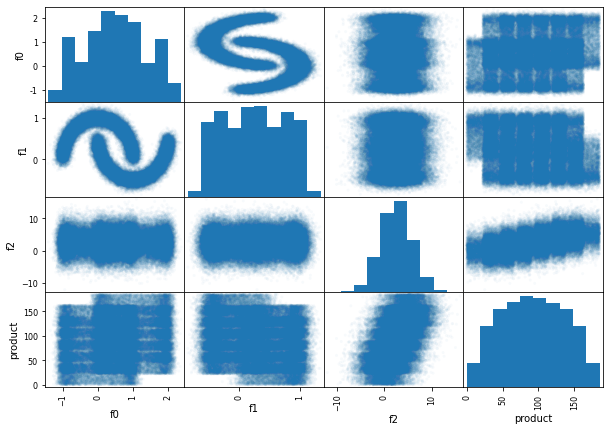

In [4]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
first_look(data_1)

Первые строки (5 шт):
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

Общее описание набора данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Основные статистические характеристики:

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.1

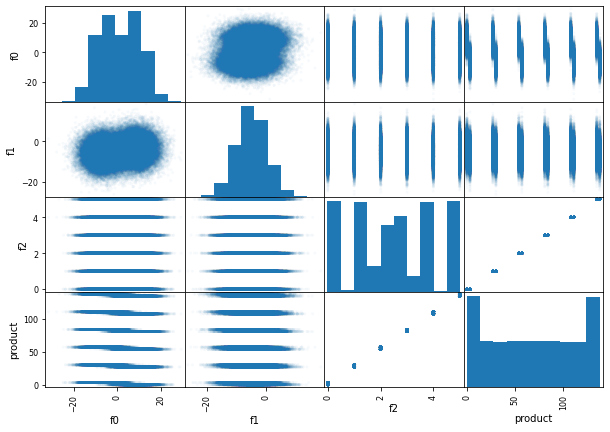

In [5]:
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
first_look(data_2)

Настораживает вид диаграммы рассеяния для f2 и product. Посмотрим количество уникальных значений в этих столбцах.

In [6]:
# количество уникальных значений f2	
len(data_2['f2'].unique())

100000

In [7]:
# количество уникальных значений product
len(data_2['product'].unique())

12

In [8]:
# список уникальных значений product
data_2['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

Видим, что в этом наборе данных в столбце product встречается всего 12 уникальных значений.

Первые строки (5 шт):
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

Общее описание набора данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Основные статистические характеристики:

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -

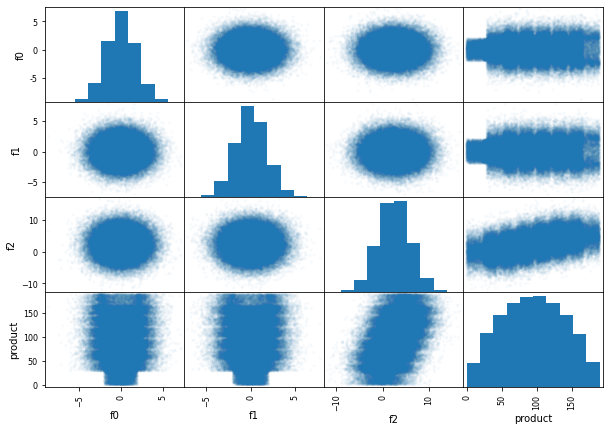

In [9]:
data_3 = pd.read_csv('/datasets/geo_data_2.csv')
first_look(data_3)

**Выводы**

Во всех трех наборах данных по 10000 строк. Нет пропусков и дубликатов. Нам доступны три характеристики по каждому объекту. Все они являются числовыми, категориальных нет. Диапазон значений по каждой характеристике разный для каждого набора данных.

Гистограммы числовых характеристик в целом похожи на нормальное распределение. Отличаются только гистограммы столбцов f0 в первом наборе данных и f2 во втором. Распределение объемов запасов в скважинах тоже напоминает нормальное распределение для первого и третьего наборов данных. Во втором наборе много скважин с минимальным или максимальным объемом запасов. 

Во всех датасетах заметно наличие корреляции между величиной f2 объемом запасов в скважине. Особенно сильно это проявляется во втором регионе, там коэффициент корреляции очень близок к 1.

In [10]:
data_2[data_2['id'].duplicated()]

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [11]:
data_2[data_2['id'] == 'wt4Uk']

,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


### Разбивка на выборки

Подготовим данные для обучения модели. Создадим переменные, содержащие характеристики и целевой признак.

In [12]:
def get_features_and_target(df):
    features = df.loc[:, ['f0', 'f1', 'f2']]
    print('Характеристики')
    print(features.head())
    print()
    print('Целевой признак')
    target = df['product']
    print(target.head())
    return features, target

In [13]:
# первый набор данных
features_1, target_1 = get_features_and_target(data_1)

Характеристики
         f0        f1        f2
0  0.705745 -0.497823  1.221170
1  1.334711 -0.340164  4.365080
2  1.022732  0.151990  1.419926
3 -0.032172  0.139033  2.978566
4  1.988431  0.155413  4.751769

Целевой признак
0    105.280062
1     73.037750
2     85.265647
3    168.620776
4    154.036647
Name: product, dtype: float64


In [14]:
# второй набор данных
features_2, target_2 = get_features_and_target(data_2)

Характеристики
          f0         f1        f2
0 -15.001348  -8.276000 -0.005876
1  14.272088  -3.475083  0.999183
2   6.263187  -5.948386  5.001160
3 -13.081196 -11.506057  4.999415
4  12.702195  -8.147433  5.004363

Целевой признак
0      3.179103
1     26.953261
2    134.766305
3    137.945408
4    134.766305
Name: product, dtype: float64


In [15]:
# третий набор данных
features_3, target_3 = get_features_and_target(data_3)

Характеристики
         f0        f1        f2
0 -1.146987  0.963328 -0.828965
1  0.262778  0.269839 -2.530187
2  0.194587  0.289035 -5.586433
3  2.236060 -0.553760  0.930038
4 -0.515993  1.716266  5.899011

Целевой признак
0     27.758673
1     56.069697
2     62.871910
3    114.572842
4    149.600746
Name: product, dtype: float64


Полученные переменные разобьём на обучающую и валидационную выборки.

In [16]:
# функция разбивает данные на подвыборки и проверяет корректность разбиения
def get_tran_test_split_and_check(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state = RANDOM_STATE
    )
    if (features_train.shape[0] + features_valid.shape[0] == features.shape[0] and
        target_train.shape[0] + target_valid.shape[0] == target.shape[0]
    ):
        print('Разделение на выборки прошло корректно')
    return features_train, features_valid, target_train, target_valid

In [17]:
# первый набор данных
features_train_1, features_valid_1, target_train_1, target_valid_1 = get_tran_test_split_and_check(
    features_1,
    target_1
)

Разделение на выборки прошло корректно


In [18]:
# второй набор данных
features_train_2, features_valid_2, target_train_2, target_valid_2 = get_tran_test_split_and_check(
    features_2,
    target_2
)

Разделение на выборки прошло корректно


In [19]:
# третий набор данных
features_train_3, features_valid_3, target_train_3, target_valid_3 = get_tran_test_split_and_check(
    features_3,
    target_3
)

Разделение на выборки прошло корректно


**Вывод**

Для каждого набора данных мы выделили переменные, содержащие характеристики и целевой признак, и полученные переменные разбили на обучающие и валидационные выборки.

### Масштабирование данных

Так как разброс характеристик по числовым значениям отличается внутри каждого датасета, проведем масштабирование данных. 

In [20]:
# отключим вывод предупреждений
pd.options.mode.chained_assignment = None

In [21]:
# список столбцов, которые содержат числовые характеристики
features_columns = ['f0', 'f1', 'f2']

Напишем функцию, которая будет масштабировать числовые характеристики данных и для проверки корректности работы выводить две гистограммы: до масштабирования и после.

In [22]:
def scaling_hists(df, features_columns, title):
    # строим гистограммы
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(title)
    fig.set_figwidth(12)
    fig.set_figheight(2)
    
    ax1.hist(df[features_columns[0]])
    ax1.set_xlabel("f0")
    ax2.hist(df[features_columns[1]])
    ax2.set_xlabel("f1")
    ax3.hist(df[features_columns[2]])
    ax3.set_xlabel("f2")

In [23]:
def scale_data(df_train, df_valid, features_columns):
    # строим гистограммы до масштабирования
    scaling_hists(df_train, features_columns, 'TRAIN Числовые характеристики до масштабирования')
    
    # используем StandardScaler: настраиваем его на имеющихся данных и преобразуем эти данные
    # настраиваем StadardScaler и масштабируем тренировочную выборку
    scaler = StandardScaler()  
    df_train[features_columns] = scaler.fit_transform(df_train[features_columns])
    scaling_hists(df_train, features_columns, 'Числовые характеристики после масштабирования')
    
    # масштабируем валидационную выборку
    scaling_hists(df_valid, features_columns, 'VALID Числовые характеристики до масштабирования')
    df_valid[features_columns] = scaler.transform(df_valid[features_columns])
    scaling_hists(df_valid, features_columns, 'Числовые характеристики после масштабирования')
    
    return df_train[features_columns], df_valid[features_columns]

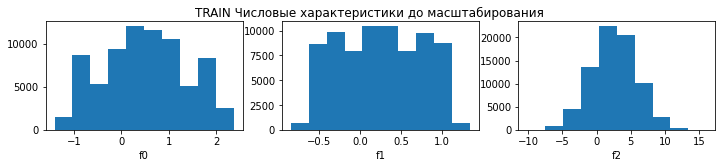

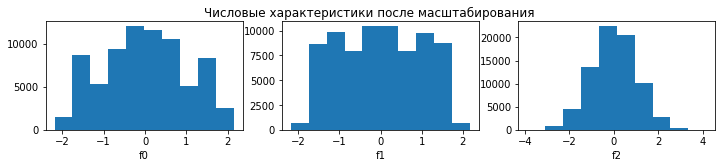

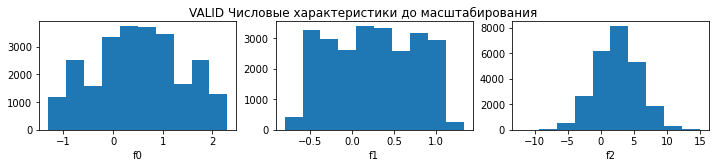

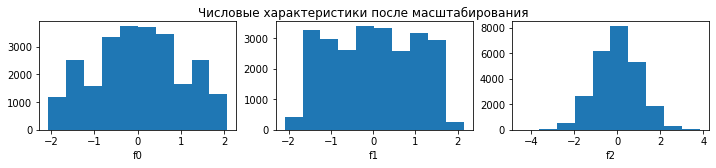

In [24]:
features_train_1[features_columns], features_valid_1[features_columns] = scale_data(
    features_train_1, 
    features_valid_1,
    features_columns
)

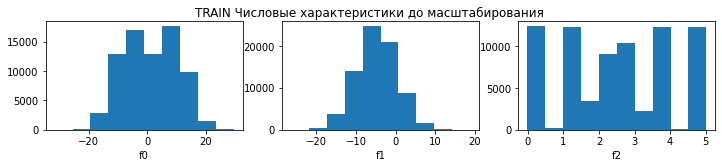

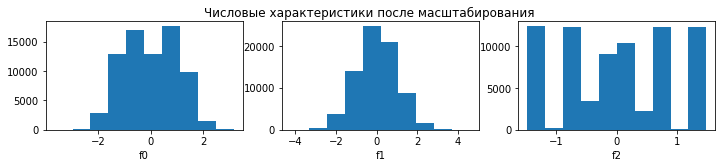

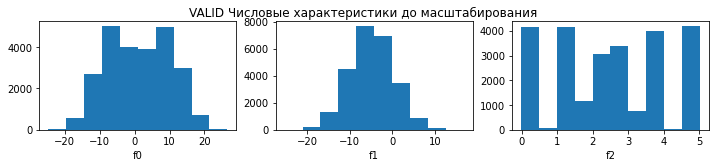

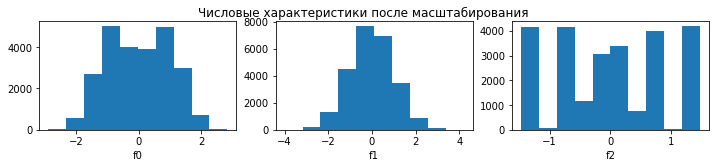

In [25]:
features_train_2[features_columns], features_valid_2[features_columns] = scale_data(
    features_train_2, 
    features_valid_2,
    features_columns
)

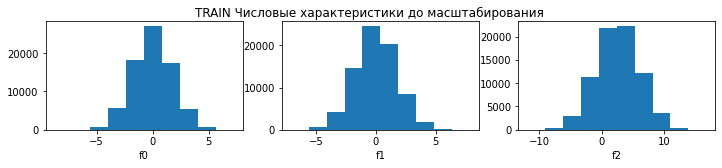

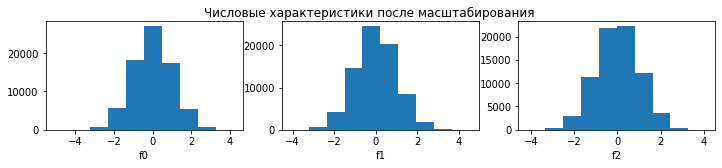

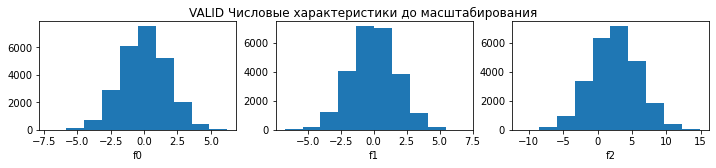

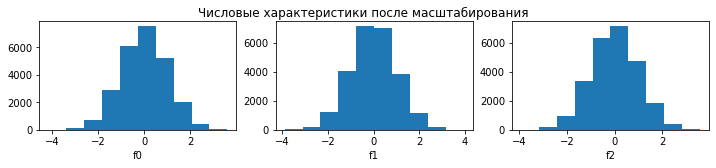

In [26]:
features_train_3[features_columns], features_valid_3[features_columns] = scale_data(
    features_train_3, 
    features_valid_3,
    features_columns
)

После масштабирования числовые характеристики во всех датасетах находятся в диапазоне от -4 до 4.

### Выводы

Для обучения модели мы загрузили и подготовили три набора данных.

Во всех наборах по 10000 строк. Пропусков и дубликатов нет. Нам доступны три характеристики по каждому объекту. Все они являются числовыми, категориальных нет. Диапазон значений по каждой характеристике разный для каждого набора данных.

Во всех датасетах заметно наличие корреляции между величиной f2 объемом запасов в скважине. Особенно сильно это проявляется во втором регионе, там коэффициент корреляции очень близок к 1.

Распределение объемов запасов в скважинах напоминает нормальное распределение для первого и третьего наборов данных. Во втором наборе много скважин с минимальным или максимальным объемом запасов.

Для каждого набора данных мы выделили переменные, содержащие характеристики и целевой признак, и полученные переменные разбили на обучающие и валидационные выборки.

После масштабирования числовые характеристики во всех датасетах находятся в диапазоне от -4 до 4.

## Обучение и проверка модели

Обучим модель линейной регрессии для предсказания объема запасов скважины по ее характеристикам. Для оценки качества модели будем использовать RMSE модели.

Чем ниже RMSE, тем лучше модель. По итогам обучения сравним модели и выберем ту, у которой RMSE минимальная.

In [27]:
def get_and_check_model(features_train, target_train,  features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('Средний запас предсказанного сырья: ', predictions.mean())
    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    print('RMSE: ', rmse)
    return model, predictions

### Обучение моделей и сравнение оценок

In [28]:
# для первого региона
print('Первый регион')
model_1, predictions_1 = get_and_check_model(
    features_train_1, 
    target_train_1,  
    features_valid_1, 
    target_valid_1
)

Первый регион
Средний запас предсказанного сырья:  92.59256778438035
RMSE:  37.5794217150813


In [29]:
# для второго региона
print('Второй регион')
model_2, predictions_2 = get_and_check_model(
    features_train_2, 
    target_train_2,  
    features_valid_2, 
    target_valid_2
)

Второй регион
Средний запас предсказанного сырья:  68.728546895446
RMSE:  0.893099286775617


In [30]:
# для третьего региона
print('Третий регион')
model_3, predictions_3 = get_and_check_model(
    features_train_3, 
    target_train_3,  
    features_valid_3, 
    target_valid_3
)

Третий регион
Средний запас предсказанного сырья:  94.96504596800489
RMSE:  40.02970873393434


**Вывод**

Самая низкая оценка RMSE у модели, построенной для второго региона. 

In [31]:
features_train_2_1 = features_train_2.drop('f2', axis=1)
features_valid_2_1 = features_valid_2.drop('f2', axis=1)
model_2_1, predictions_2_1 = get_and_check_model(
    features_train_2_1, 
    target_train_2,  
    features_valid_2_1, 
    target_valid_2
)

Средний запас предсказанного сырья:  68.85899112906351
RMSE:  46.006958160915644


### Вывод

Мы обучили модель линейной регрессии для предсказания объема запасов скважины по ее характеристикам для каждого региона.

Самая низкая оценка RMSE у модели, построенной для второго региона. 

Самый высокий средний запас сырья в третьем и первом регионах

Самый низкий – во втором.

## Подготовка к расчёту прибыли

Для расчета прибыли по региону, сначала рассчитаем достаточный объем сырья для безубыточной разработки одной новой скважины.

### Расчет характеристик одной скважины

При разведке региона исследуют 500 точек, из них выбирают 200 лучших для разработки. Бюджет на разработку скважин в регионе – 10 млрд рублей. Узнаем, какая сумма приходится на одну скважину из 200

In [32]:
MONEY_FOR_ONE_OIL_WELL = MONEY_FOR_DEVELOPMENT / NUMBER_OF_OIL_WELLS
MONEY_FOR_ONE_OIL_WELL

50000000.0

Посчитаем объем сырья, достаточный для безубыточной разработки: разделим расходы (50 000 000) на доход с тысячи баррелей (450 000)

In [33]:
SUFFICIENT_AMOUNT_OF_OIL = round(MONEY_FOR_ONE_OIL_WELL / PROFIT_OF_ONE_THOUSAND_BARRELS)
SUFFICIENT_AMOUNT_OF_OIL

111

### Сравнение со средним по регионам

Выведем средние показатели по предсказаниям по регионам

In [34]:
predictions_1.mean(), predictions_2.mean(), predictions_3.mean()

(92.59256778438035, 68.728546895446, 94.96504596800489)

**Вывод**

Средний запас третьего региона ближе всего к искомым показателям.

### Выводы

На разработку одной скважины в среднем тратится 50 000 000 рублей. Для безубыточной разработки необходимо, чтобы минимальный объём запаса скважины составлял 111 тыс. баррелей.

Ближе всего к искомым показателям средние запасы первого и третьего регионов.

## Расчёт прибыли и рисков 

### Расчет прибыли

Посчитаем ожидаемую прибыль с региона. Для этого отсортируем предсказания по убыванию и выберем 200 самых богатых скважин.

In [35]:
# напишем функцию расчета валовой прибыли

def profit(predictions, target):
    
    # выберем 200 самых богатых скважин
    predict_sorted = predictions.sort_values(ascending=False)
    target_sorted = target.loc[predict_sorted.index][:NUMBER_OF_OIL_WELLS]
    
    # отнимем от прибыли, которую дает регион, затраты на его разработку
    profit = sum(target_sorted) * PROFIT_OF_ONE_THOUSAND_BARRELS - MONEY_FOR_DEVELOPMENT
    
    return profit

In [36]:
#ячейка ревьюера
'''индексы НЕ совпадают'''

target_valid_1, predictions_1

(71751     10.038645
 80493    114.551489
 2655     132.603635
 53233    169.072125
 91141    122.325180
             ...    
 12581    170.116726
 18456     93.632175
 73035    127.352259
 63834     99.782700
 43558    177.821022
 Name: product, Length: 25000, dtype: float64,
 array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
        118.18039721, 118.16939229]))

In [37]:
#ячейка ревьюера
'''индексы совпадают'''

target_valid_1.reset_index(drop = True), pd.Series(predictions_1)

(0         10.038645
 1        114.551489
 2        132.603635
 3        169.072125
 4        122.325180
             ...    
 24995    170.116726
 24996     93.632175
 24997    127.352259
 24998     99.782700
 24999    177.821022
 Name: product, Length: 25000, dtype: float64,
 0         95.894952
 1         77.572583
 2         77.892640
 3         90.175134
 4         70.510088
             ...    
 24995    103.037104
 24996     85.403255
 24997     61.509833
 24998    118.180397
 24999    118.169392
 Length: 25000, dtype: float64)

Изменим индексы в переменных, содержащих целевой признак так, чтобы они шли по порядку.

In [38]:
target_valid_1 = target_valid_1.reset_index(drop = True)
target_valid_2 = target_valid_2.reset_index(drop = True)
target_valid_3 = target_valid_3.reset_index(drop = True)

Рассчитаем прибыль по регионам в миллионах

In [39]:
print('Прогнозируемая прибыль')
print(f'для первого региона: {profit(pd.Series(predictions_1), target_valid_1) / 10e6:.4f} млн')
print(f'для второго региона: {profit(pd.Series(predictions_2), target_valid_2) / 10e6:.4f} млн')
print(f'для третьего региона: {profit(pd.Series(predictions_3), target_valid_3) / 10e6:.4f} млн')

Прогнозируемая прибыль
для первого региона: 332.0826 млн
для второго региона: 241.5087 млн
для третьего региона: 271.0350 млн


Расчет прибыли показал, что максимальная прибыль ожидается от разработки первого региона.

### Расчет рисков для каждого региона

Для прогнозирования возможных  убытков рассчитаем распределение прибыли с помощью техники Bootstrap .

Напишем функцию для нахождения распределения прибыли по региону при разработке двухсот лучших скважин из пятисот случайно выбранных.

In [40]:
# Сформируем 1000 выборок по 500 месторождений 
# и вызовем для каждой выборки функцию расчета прибыли.

def create_profit_series_on_predictions(predictions, target_valid):
    bootstrap_samples = 1000
    profit_list = []
    state = np.random.RandomState(12345)

    for iteraion in range(bootstrap_samples):
        target_500 = target_valid.sample(
            n=500,
            replace=True,
            random_state=state
        )
        predict_500 = predictions[target_500.index]
        profit_list.append(profit(predict_500, target_500))
    
    return pd.Series(profit_list)

Напишем функцию для нахождения по полученному распределению прибыли среднего дохода с региона, 95%-ного доверительного региона и вероятности убытков.

In [42]:
def get_statistics(predicions, target_valid):
    profit_list = create_profit_series_on_predictions(pd.Series(predicions), target_valid)
    # находим среднюю ожидаемую прибыль
    print(f'Средняя прибыль: {profit_list.mean() / 1e6:.2f} млн')
    
    # найдем 95%-й доверительный интервал
    print('95%-й доверительный интервал:')
    print(count_confidence_interval(profit_list))

    # Посчитаем вероятность отрицательной прибыли как 
    #долю количества убыточных разработок от общего числа
    print('Риск убытков:', len(profit_list[profit_list<0])/len(profit_list)*100, '%')


Проведем расчеты для каждого региона.

In [43]:
# для первого региона
print('Первый регион')
get_statistics(predictions_1, target_valid_1)

Первый регион
Средняя прибыль: 42.59 млн
95%-й доверительный интервал:
(-102090094.83793645, 947976353.3583689)
Риск убытков: 6.0 %


In [44]:
# для второго региона
print('Второй регион')
get_statistics(predictions_2, target_valid_2)

Второй регион
Средняя прибыль: 51.52 млн
95%-й доверительный интервал:
(68873225.37051702, 931547591.2570724)
Риск убытков: 1.0 %


In [45]:
# для третьего региона
print('Третий регион')
get_statistics(predictions_3, target_valid_3)

Третий регион
Средняя прибыль: 43.50 млн
95%-й доверительный интервал:
(-128880547.32978535, 969706954.1802661)
Риск убытков: 6.4 %


### Выводы

Для первого и третьего регионов риск убытков выше 2,5% (левая граница доверительного интервала – отрицательное число). **Самый низкий риск убытков во втором регионе – всего 1%**.

По результатам вычислений **самая высокая средняя прибыль наблюдается во втором регионе – 51,5 млн рублей**.


## Общий вывод

Для построения модели, которая определит самый прибыльный регион для разработки нефти, мы загрузили и подготовили три набора данных.

Во всех наборах по 10000 строк. Пропусков и дубликатов нет. Нам доступны три характеристики по каждому объекту. Все они являются числовыми, категориальных нет. 

Для каждого набора данных мы выделили переменные, содержащие характеристики и целевой признак, и полученные переменные разбили на обучающие и валидационные выборки. После масштабирования числовые характеристики во всех датасетах находятся в диапазоне от -4 до 4.

Мы обучили модель линейной регрессии для предсказания объема запасов скважины по ее характеристикам для каждого региона.

Самая удачная модель – модель, разработанная для второго региона, у нее самая низкая оценка RMSE (0.893). 

Мы провели анализ среднего запаса сырья. Самый высокий - в третьем и первом регионах.

На разработку одной скважины в среднем тратится 50 000 000 рублей. Для безубыточной разработки необходимо, чтобы минимальный объём запаса скважины составлял 111 тыс. баррелей.

Ближе всего к искомым показателям средние запасы первого и третьего регионов.

По результатам исследования **самым выгодным для разработки нам кажется второй регион**, так как он:

- по прогнозируемой средней прибыли занимает первое место (51,5 млн рублей)
- риск убытков для этого региона самый низкий из всех проанализированных (1%)
